# Analysis on correlation between earthquakes and surface mass loading

In [276]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

In [4]:
# import sys
# !{sys.executable} -m pip install netcdf4

### 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [5]:
# GRACE data
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [6]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [268]:
depth = cat['depth']
catalog['depth'] = depth

### 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [300]:
etas_declustered = catalog[catalog['P_triggered']<.9]

### 3. Add surface load data to the earthquake dataframes

In [10]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
etas_declustered['dmass'] = etas_declustered.apply(lambda row: get_mass(row), axis=1)
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [272]:
# etas_declustered.to_csv('etas_declustered.csv')

In [273]:
# catalog.to_csv('catalog.csv')

#### Are the mean/meadian values different between: 1. The whole dataset, 2. times with earthquakes, and 3. times with earthquakes that have low probability of being triggered?
The answer appears to be: no, not really. The Bayesian analysis explains why! It's because the declustered catalog are favored at large positive AND negative surface loads. The symmetry implies that the means don't change much.

In [11]:
print('ETAS declustered mean:   %f'%etas_declustered['dmass'].mean())
print('ETAS declustered median: %f'%etas_declustered['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

ETAS declustered mean:   0.441004
ETAS declustered median: 0.284740
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


### 4. Analyze correlation between all events and surface mass loading

In [12]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics:
    
- CramerVonMisesResult(statistic=18.386893296385097, pvalue=3.1430320568404113e-09),
- KstestResult(statistic=0.05779103923331644, pvalue=6.212789284386416e-37),
- 'median_all': 0.749170696239575,
- 'median_eq': array(1.05422887),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 0.8274112789242835,
- 'mean_all_minus_mean_eq': -1.4812864573380033,
- 'median_all_minus_median_eq': -0.30505817015141257}

In [279]:
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

## 5. Correlation between ETAS declustered catalog and surface mass loading

#### Both statistical tests produce p-values < 0.05, which indicate that the two samples are not drawn from the same distribution. This means that the distribution of surface mass load during earthquake occurrence is significantly different from background.

In [15]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)
# loadquakes.calc_stats(np.array(etas_declustered.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics

- 'cvm': CramerVonMisesResult(statistic=18.38713838188511, pvalue=3.178242002910281e-09),
- 'ks': KstestResult(statistic=0.0833189806824356, pvalue=0.0010844083570850202),
- 'median_all': 0.749170696239575,
- 'median_eq': array(0.2847398),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 0.44100372833838036,
- 'mean_all_minus_mean_eq': -1.0948789067521003,
- 'median_all_minus_median_eq': 0.46443089594810544}

#### The conditional probability will change quantitatively depending on the bin size. However, the same qualitative distribution remains, where there is a higher relative conditional probability during periods of large loading and unloading. 

#### Here, we calculate the Bayesian probability using two different bin sizes which are calculated via two methods:

##### a. Sturge's Rule
##### b. Freedman-Diaconis Rule


21
20


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


71
70


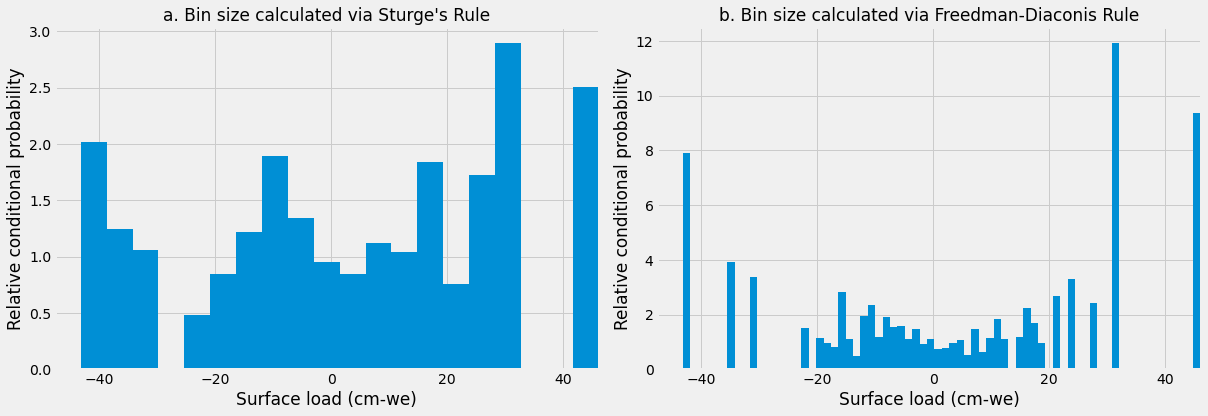

In [17]:
importlib.reload(loadquakes)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')
    
loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), etas_declustered.dmass, ax1,
                      "a. Bin size calculated via Sturge's Rule", method='Sturge')

loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), etas_declustered.dmass, ax2,
                      "b. Bin size calculated via Freedman-Diaconis Rule", method='fd')

fig.tight_layout()


## 6. Mapping earthquakes with high conditional probability

### First, calculate the conditional probability of each event

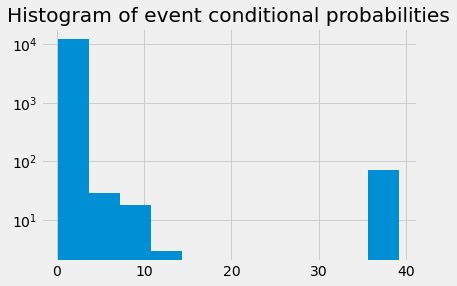

In [19]:
# Full catalog 

conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(catalog.dmass), np.array(catalog.dmass), 'fd')
catalog['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(catalog['cp']),11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


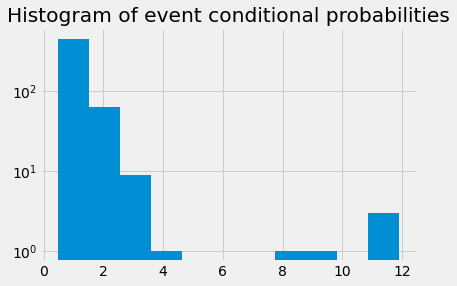

In [20]:
# ETAS declustered

conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(etas_declustered.dmass), np.array(etas_declustered.dmass), 'fd')
etas_declustered['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(etas_declustered['cp']),11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

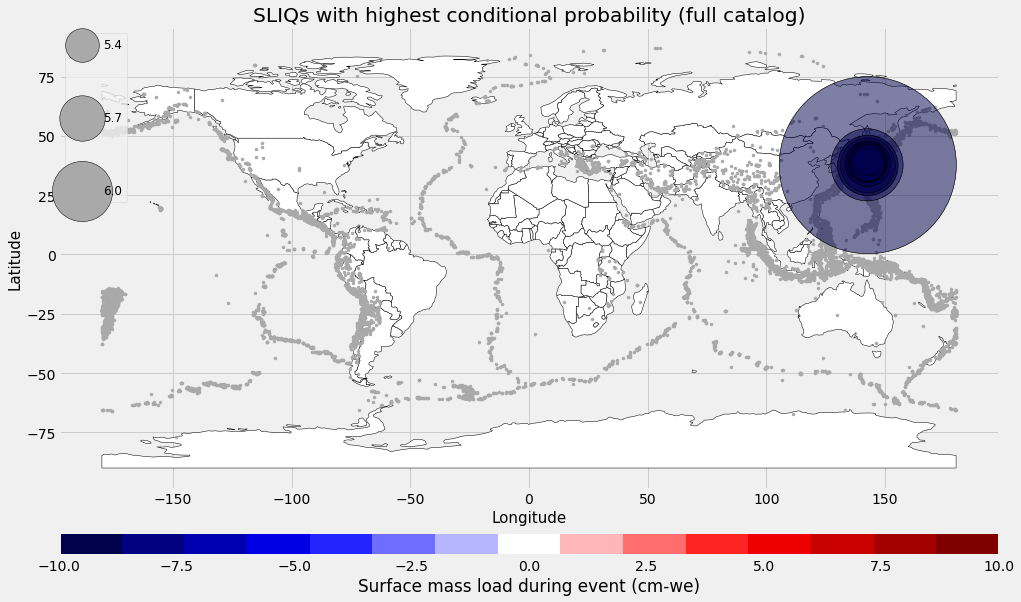

In [286]:
loadquakes.load_map_cb(catalog,sliq_full.head(10),sliq_full.head(10).dmass, [1,8,6],
                'SLIQs with highest conditional probability (full catalog)',-10,10,11)

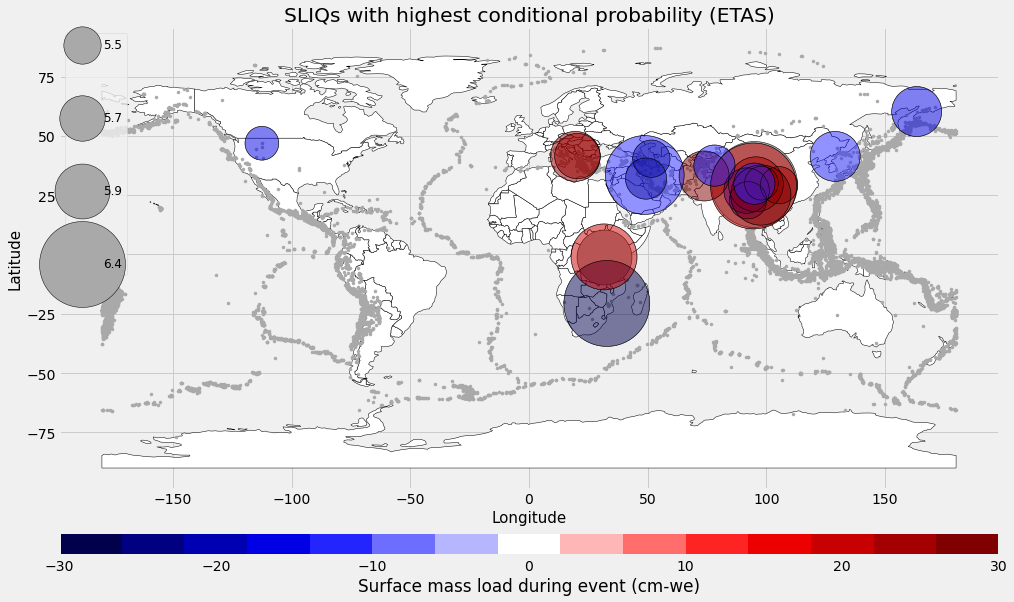

In [290]:
loadquakes.load_map_cb(catalog,sliq_etas.head(20),sliq_etas.head(20).dmass, [1,2,3,5],
                'SLIQs with highest conditional probability (ETAS)',-30,30,11)

### Next, we examine the depth of a SLIQ compared to the depth of all events in the full catalog and ETAS declustered catalog.

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


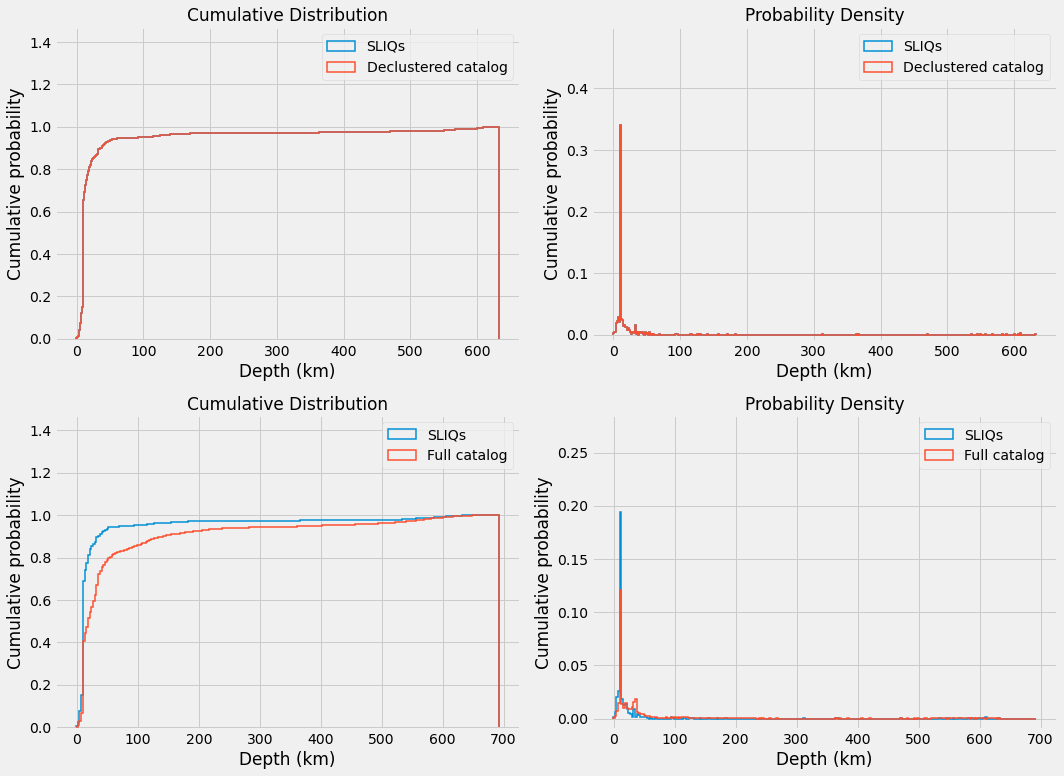

In [295]:
importlib.reload(loadquakes)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,11))

loadquakes.depth_fig(ax1,etas_declustered,True,'Declustered catalog',"Cumulative Distribution",sliq_etas)
loadquakes.depth_fig(ax2,etas_declustered,False,'Declustered catalog','Probability Density',sliq_etas)
loadquakes.depth_fig(ax3,catalog,True,'Full catalog',"Cumulative Distribution",sliq_etas)
loadquakes.depth_fig(ax4,catalog,False,'Full catalog','Probability Density',sliq_etas)

fig.tight_layout()

### Depth statistics:

In [123]:
print('Catalog mean:   %f'%catalog['depth'].mean())
print('Catalog median:   %f'%catalog['depth'].median())

print('Declustered catalog mean:   %f'%etas_declustered['depth'].mean())
print('Declustered catalog median: %f'%etas_declustered['depth'].median())

print('SLIQ mean:   %f'%sliq_etas['depth'].mean())
print('SLIQ median:   %f'%sliq_etas['depth'].median())

Catalog mean:   63.111372
Catalog median:   20.000000
Declustered catalog mean:   31.788479
Declustered catalog median: 10.000000
SLIQ mean:   31.788479
SLIQ median:   10.000000


In [124]:
sliq_etas.to_csv('sliq_etas.csv', index=False)

## 7. Correlation between earthquakes and random data
##### *mean and std deviation of random array same as GRACE data 

In [296]:
random_load1 = np.random.normal(loc=np.mean(ds['lwe_thickness']), 
                                scale=np.std(ds['lwe_thickness']), 
                                size=(205, 360, 720))

In [47]:
ds_random = ds

In [48]:
ds_random = ds_random.assign(load=ds_random['lwe_thickness'] - ds_random['lwe_thickness'] + random_load1)

In [49]:
# earthquake catalog

etas_declustered_random = catalog[catalog['P_triggered']<.9]

In [50]:
def get_mass_random(eq):
    mass_change = ds_random.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["load"]
    return mass_change.data
  
etas_declustered_random['dmass'] = etas_declustered_random.apply(lambda row: get_mass_random(row), axis=1)

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


18


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


18
17


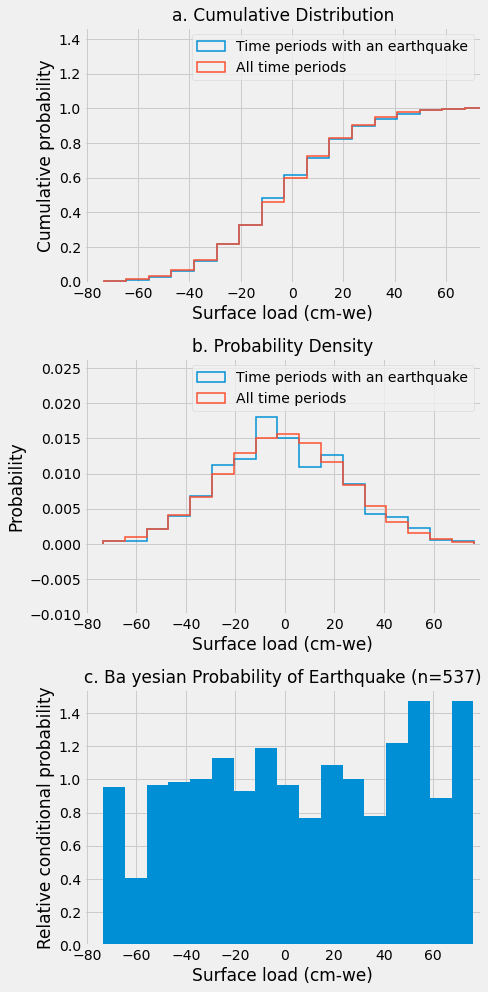

In [51]:
set_of_figures_load(ds_random['load'].data.flatten(), 
                    etas_declustered_random.dmass,'c. Ba yesian Probability of Earthquake (n=537)',
                    'fd')

In [52]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(etas_declustered_random.dmass),np.array(ds_random['load'].data.flatten()))

### Statistics:

- CramerVonMisesResult(statistic=0.17526630647677166, pvalue=0.3209730702334621),
- KstestResult(statistic=0.034015491711791634, pvalue=0.5517688029164669),
- 'median_all': -0.6580511187055076,
- 'median_eq': array(0.95553539),
- 'mean_all': -0.655453456680114,
- 'mean_eq': 0.04997674867629525,
- 'mean_all_minus_mean_eq': -0.7054302053564092,
- 'median_all_minus_median_eq': -1.6135865102031677}

## 8. Correlation between moderately clustered catalog (NND) and surface mass loading

In [53]:
NND_declustered_ind = pd.read_csv('NND_declustered_catalog.csv')
NND_declustered_ind = NND_declustered_ind.to_numpy()[:, -1]

In [54]:
NND_declustered = catalog.iloc[NND_declustered_ind]

In [301]:
importlib.reload(loadquakes)

# set_of_figures_load(ds['lwe_thickness'].data.flatten(), NND_declustered.dmass,
#                     'c. Bayesian Probability of Event (n=9865)','fd')

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

31
30


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


376
375


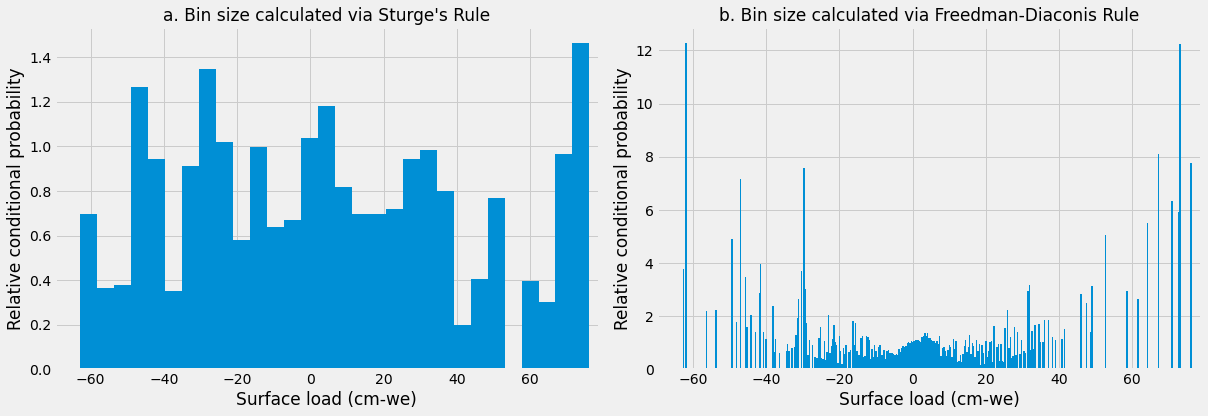

In [57]:
importlib.reload(loadquakes)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')
    
loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), NND_declustered.dmass, ax1,
                      "a. Bin size calculated via Sturge's Rule", method='Sturge')

loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), NND_declustered.dmass, ax2,
                      "b. Bin size calculated via Freedman-Diaconis Rule", method='fd')

fig.tight_layout()


In [58]:
print('NND declustered mean:   %f'%NND_declustered['dmass'].mean())
print('NND declustered median: %f'%NND_declustered['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

NND declustered mean:   1.026598
NND declustered median: 1.046250
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


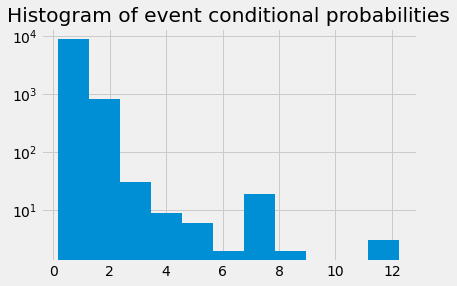

In [60]:
nnd_conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(NND_declustered.dmass), np.array(NND_declustered.dmass), 'fd')
NND_declustered['cp'] = nnd_conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(NND_declustered['cp']),11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

In [299]:
# NND_declustered.to_csv('NND_declustered.csv')

In [158]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(NND_declustered.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics:

- CramerVonMisesResult(statistic=15.77332981982454, pvalue=4.454382085405939e-09),
- KstestResult(statistic=0.06252798045367963, pvalue=5.755761429611317e-34),
- 'median_all': 0.749170696239575,
- 'median_eq': array(1.04625004),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 1.026597588716882,
- 'mean_all_minus_mean_eq': -1.680472767130602,
- 'median_all_minus_median_eq': -0.29707934497504307}

#  Things to do:
- discuss bigger context with supplemental figures -- describe state of global surafce mass field (regional context): Gorkha happenned during period of unloading (non-monsoon season) associated with the pre-monsoon phase of the hydrological cycle. (unseasonably early mass anomaly) - most events actually happen in the summer in Nepal.
--> consistent with Bollinger! 